In [1]:
!pip install tensorflow_model_optimization

import numpy as np
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers, datasets, utils, callbacks, optimizers, losses
from keras.datasets import cifar10
import tensorflow_model_optimization as tfmot

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.2/241.2 kB 5.6 MB/s eta 0:00:00


In [2]:
# Loading data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Data Transform
x_train = x_train.astype(np.float32) / 255.0
y_train = utils.to_categorical(y_train)
x_train_mean = np.mean(x_train, axis=0)
x_train -= x_train_mean

x_test = x_test.astype(np.float32) / 255.0
y_test = utils.to_categorical(y_test)
x_test -= x_train_mean

170498071/170498071 [==============================] - 3s 0us/step


### ResNet18

In [3]:
# # @title 기본 제목 텍스트
# kernel_initializer = 'he_normal'
# input_shape = (32,32,3)

# image_input = layers.Input(shape=input_shape)
# # first layer

# block1 = keras.Sequential([
#     layers.Conv2D(kernel_size=3, filters=64, strides=1, padding='same', kernel_initializer=kernel_initializer),
#     layers.BatchNormalization(),
#     layers.ReLU()
# ])(image_input)

# # first stage
# shortcut = block1
# block2 = keras.Sequential([
#     layers.Conv2D(filters=64, kernel_size=3, strides=1, padding='same', kernel_initializer=kernel_initializer),
#     layers.BatchNormalization(),
#     layers.ReLU(),
#     layers.Conv2D(filters=64, kernel_size=3, strides=1, padding='same', kernel_initializer=kernel_initializer),
#     layers.BatchNormalization()
# ])(block1)

# block2 = layers.add([block2, shortcut])
# block2 = layers.ReLU()(block2)

# shortcut = block2
# block3 = keras.Sequential([
#     layers.Conv2D(filters=64, kernel_size=3, strides=1, padding='same', kernel_initializer=kernel_initializer),
#     layers.BatchNormalization(),
#     layers.ReLU(),
#     layers.Conv2D(filters=64, kernel_size=3, strides=1, padding='same', kernel_initializer=kernel_initializer),
#     layers.BatchNormalization()
# ])(block2)

# block3 = layers.add([block3, shortcut])
# block3 = layers.ReLU()(block3)

# # second stage
# shortcut = keras.Sequential([layers.Conv2D(filters=128, kernel_size=1, strides=2),
#                              layers.BatchNormalization()])(block3)
# block4 = keras.Sequential([
#     layers.Conv2D(filters=128, kernel_size=3, strides=2, padding='same', kernel_initializer=kernel_initializer),
#     layers.BatchNormalization(),
#     layers.ReLU(),
#     layers.Conv2D(filters=128, kernel_size=3, strides=1, padding='same', kernel_initializer=kernel_initializer),
#     layers.BatchNormalization()
# ])(block3)

# block4 = layers.add([block4, shortcut])
# block4 = layers.ReLU()(block4)

# shortcut = block4
# block5 = keras.Sequential([
#     layers.Conv2D(filters=128, kernel_size=3, strides=1, padding='same', kernel_initializer=kernel_initializer),
#     layers.BatchNormalization(),
#     layers.ReLU(),
#     layers.Conv2D(filters=128, kernel_size=3, strides=1, padding='same', kernel_initializer=kernel_initializer),
#     layers.BatchNormalization()
# ])(block4)

# block5 = layers.add([block5, shortcut])
# block5 = layers.ReLU()(block5)

# # third stage
# shortcut = keras.Sequential([layers.Conv2D(filters=256, kernel_size=1, strides=2),
#                              layers.BatchNormalization()])(block5)
# block6 = keras.Sequential([
#     layers.Conv2D(filters=256, kernel_size=3, strides=2, padding='same', kernel_initializer=kernel_initializer),
#     layers.BatchNormalization(),
#     layers.ReLU(),
#     layers.Conv2D(filters=256, kernel_size=3, strides=1, padding='same', kernel_initializer=kernel_initializer),
#     layers.BatchNormalization()
# ])(block5)

# block6 = layers.add([block6, shortcut])
# block6 = layers.ReLU()(block6)

# shortcut = block6
# block7 = keras.Sequential([
#     layers.Conv2D(filters=256, kernel_size=3, strides=1, padding='same', kernel_initializer=kernel_initializer),
#     layers.BatchNormalization(),
#     layers.ReLU(),
#     layers.Conv2D(filters=256, kernel_size=3, strides=1, padding='same', kernel_initializer=kernel_initializer),
#     layers.BatchNormalization()
# ])(block6)

# block7 = layers.add([block7, shortcut])
# block7 = layers.ReLU()(block7)

# #fourth stage
# shortcut = keras.Sequential([layers.Conv2D(filters=512, kernel_size=1, strides=2),
#                              layers.BatchNormalization()])(block7)
# block8 = keras.Sequential([
#     layers.Conv2D(filters=512, kernel_size=3, strides=2, padding='same', kernel_initializer=kernel_initializer),
#     layers.BatchNormalization(),
#     layers.ReLU(),
#     layers.Conv2D(filters=512, kernel_size=3, strides=1, padding='same', kernel_initializer=kernel_initializer),
#     layers.BatchNormalization()
# ])(block7)

# block8 = layers.add([block8, shortcut])
# block8 = layers.ReLU()(block8)

# shortcut = block8
# block9 = keras.Sequential([
#     layers.Conv2D(filters=512, kernel_size=3, strides=1, padding='same', kernel_initializer=kernel_initializer),
#     layers.BatchNormalization(),
#     layers.ReLU(),
#     layers.Conv2D(filters=512, kernel_size=3, strides=1, padding='same', kernel_initializer=kernel_initializer),
#     layers.BatchNormalization()
# ])(block8)

# block9 = layers.add([block9, shortcut])
# block9 = layers.ReLU()(block9)

# predictions = keras.Sequential([
#     layers.GlobalAveragePooling2D(),
#     layers.Flatten(),
#     layers.Dense(10)
# ])(block9)

# model = keras.Model(inputs=image_input, outputs=predictions)

In [4]:
## Applying bottleneck
def bottleneck_block(input, filters=64, expansion=1, stride=1):
    x = layers.Conv2D(filters, (1, 1), padding='same')(input)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # x = layers.Conv2D(filters, (3, 3), padding='same', strides=stride)(x)
    x = layers.DepthwiseConv2D(3, padding='same', strides=stride)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(filters*expansion, (1, 1), padding='same')(x)
    x = layers.BatchNormalization()(x)

    if (stride == 2 or expansion==4):
        input = layers.Conv2D(filters*expansion, (1, 1), padding='same', strides=stride)(input)
        input = layers.BatchNormalization()(input)

    x = layers.Add()([x, input])
    x = layers.ReLU()(x)
    return x

kernel_initializer = 'he_normal'
input_shape = (32,32,3)

image_input = layers.Input(shape=input_shape)
# first layer
x = keras.Sequential([
    layers.Conv2D(kernel_size=3, filters=64, strides=1, padding='same', kernel_initializer=kernel_initializer),
    layers.BatchNormalization(),
    layers.ReLU()
])(image_input)

# first stage
x = bottleneck_block(x, filters=64, expansion=1, stride=1)
x = bottleneck_block(x, filters=64, expansion=1, stride=1)
# second stage
x = bottleneck_block(x, filters=128, expansion=1, stride=2)
x = bottleneck_block(x, filters=128, expansion=1, stride=1)
# Third stage
x = bottleneck_block(x, filters=256, expansion=1, stride=2)
x = bottleneck_block(x, filters=256, expansion=1, stride=1)
# Fourth stage
x = bottleneck_block(x, filters=512, expansion=1, stride=2)
x = bottleneck_block(x, filters=512, expansion=1, stride=1)

predictions = keras.Sequential([
    layers.GlobalAveragePooling2D(),
    layers.Flatten(),
    layers.Dense(512),
    layers.Dense(10)
])(x)

model = keras.Model(inputs=image_input, outputs=predictions)

Epoch 1/50
1407/1407 [==============================] - 78s 32ms/step - loss: 1.4964 - accuracy: 0.4826 - val_loss: 1.1946 - val_accuracy: 0.5932
Epoch 2/50
1407/1407 [==============================] - 41s 29ms/step - loss: 0.9477 - accuracy: 0.6662 - val_loss: 1.0199 - val_accuracy: 0.6738
Epoch 3/50
1407/1407 [==============================] - 41s 29ms/step - loss: 0.7493 - accuracy: 0.7374 - val_loss: 0.8281 - val_accuracy: 0.7304
Epoch 4/50
1407/1407 [==============================] - 41s 29ms/step - loss: 0.6086 - accuracy: 0.7874 - val_loss: 0.6682 - val_accuracy: 0.7766
Epoch 5/50
1407/1407 [==============================] - 41s 29ms/step - loss: 0.5041 - accuracy: 0.8242 - val_loss: 0.7010 - val_accuracy: 0.7792
Epoch 6/50
1407/1407 [==============================] - 43s 30ms/step - loss: 0.4189 - accuracy: 0.8538 - val_loss: 0.7879 - val_accuracy: 0.7568
Epoch 7/50
1407/1407 [==============================] - 42s 30ms/step - loss: 0.3417 - accuracy: 0.8796 - val_loss: 0.6873 -

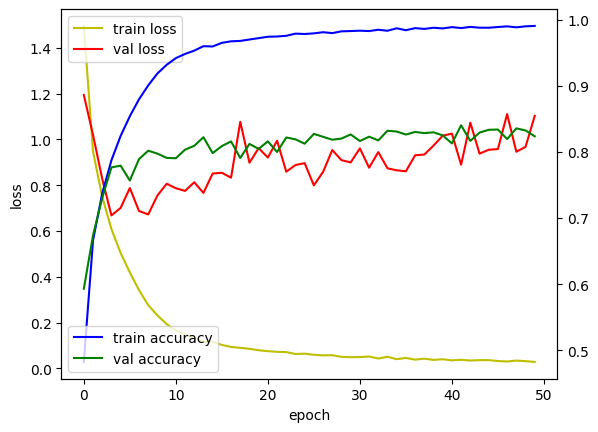

In [5]:
# from keras.callbacks import EarlyStopping
# early_stopping = EarlyStopping(monitor = 'val_loss', min_delta = 0, patience = 30, mode = 'auto')

model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

hist = model.fit(
          x_train,
          y_train,
          epochs=50,
          validation_split=0.1)
          # callbacks = [early_stopping])

# Total parameters
model.summary()

# Best Validation Accuracy
print("Best Validation Accuracy:{:.4f}".format(max(hist.history['val_accuracy'])))

#plot training
%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label = 'train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label = 'val loss')
acc_ax.plot(hist.history['accuracy'], 'b', label = 'train accuracy')
acc_ax.plot(hist.history['val_accuracy'], 'g', label = 'val accuracy')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_xlabel('accuracy')

loss_ax.legend(loc = 'upper left')
acc_ax.legend(loc = 'lower left')

plt.show()

model.save("resnet18_rev")


In [6]:
# from tensorflow import keras
# import tensorflow as tf
# import tensorflow_model_optimization as tfmot

# load pre-trained model
model = keras.models.load_model('resnet18_rev')

prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

# Compute end step to finish pruning after 2 epochs.
batch_size = 128
epochs = 2
validation_split = 0.1 # 10% of training set will be used for validation set.

num_images = x_train.shape[0] * (1 - validation_split)
end_step = np.ceil(num_images / batch_size).astype(np.int32) * epochs

# Define model for pruning.
pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.50,
                                                               final_sparsity=0.80,
                                                               begin_step=0,
                                                               end_step=end_step)
}

model_for_pruning = prune_low_magnitude(model, **pruning_params)

# `prune_low_magnitude` requires a recompile.
model_for_pruning.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model_for_pruning.summary()

callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep(),
  tfmot.sparsity.keras.PruningSummaries(),
]

hist_prune = model_for_pruning.fit(x_train, y_train,
                  batch_size=batch_size, epochs=epochs, validation_split=validation_split,
                  callbacks=callbacks)

# Best Validation Accuracy
print("Best Validation Accuracy(Prunned):{.4f}".format(max(hist_prune.history['val_accuracy'])))



Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 sequential (Sequential)     (None, 32, 32, 64)           3780      ['input_1[0][0]']             
                                                                                                  
 prune_low_magnitude_conv2d  (None, 32, 32, 64)           8258      ['sequential[0][0]']          
 _1 (PruneLowMagnitude)                                                                           
                                                                                                  
 prune_low_magnitude_batch_  (None, 32, 32, 64)           257       ['prune_low_magnitude_conv

TypeError: ignored